# YOUR PROJECT TITLE

Imports and set magics:

In [ ]:
pip install geopandas

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import plotly.graph_objects as go
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Our data 

In this data project we will investigate how smoking, obesity, social support and alcohol affects life expectancy at age 65 years old. Life expectancy at 65 is measured as the average number of years that a person at 65 years can be expected to live assuming that age-specifikc mortality levels remain constant. All data are taken from OECD (https://data.oecd.org). We look at the following data sets:

lifeexp65.csv:

alcohol.csv:

overobese.csv:

smokers.csv:

socsupport.csv:

The maps below show life expectancy at 65 for men and women in 2000 for data in our data set. 

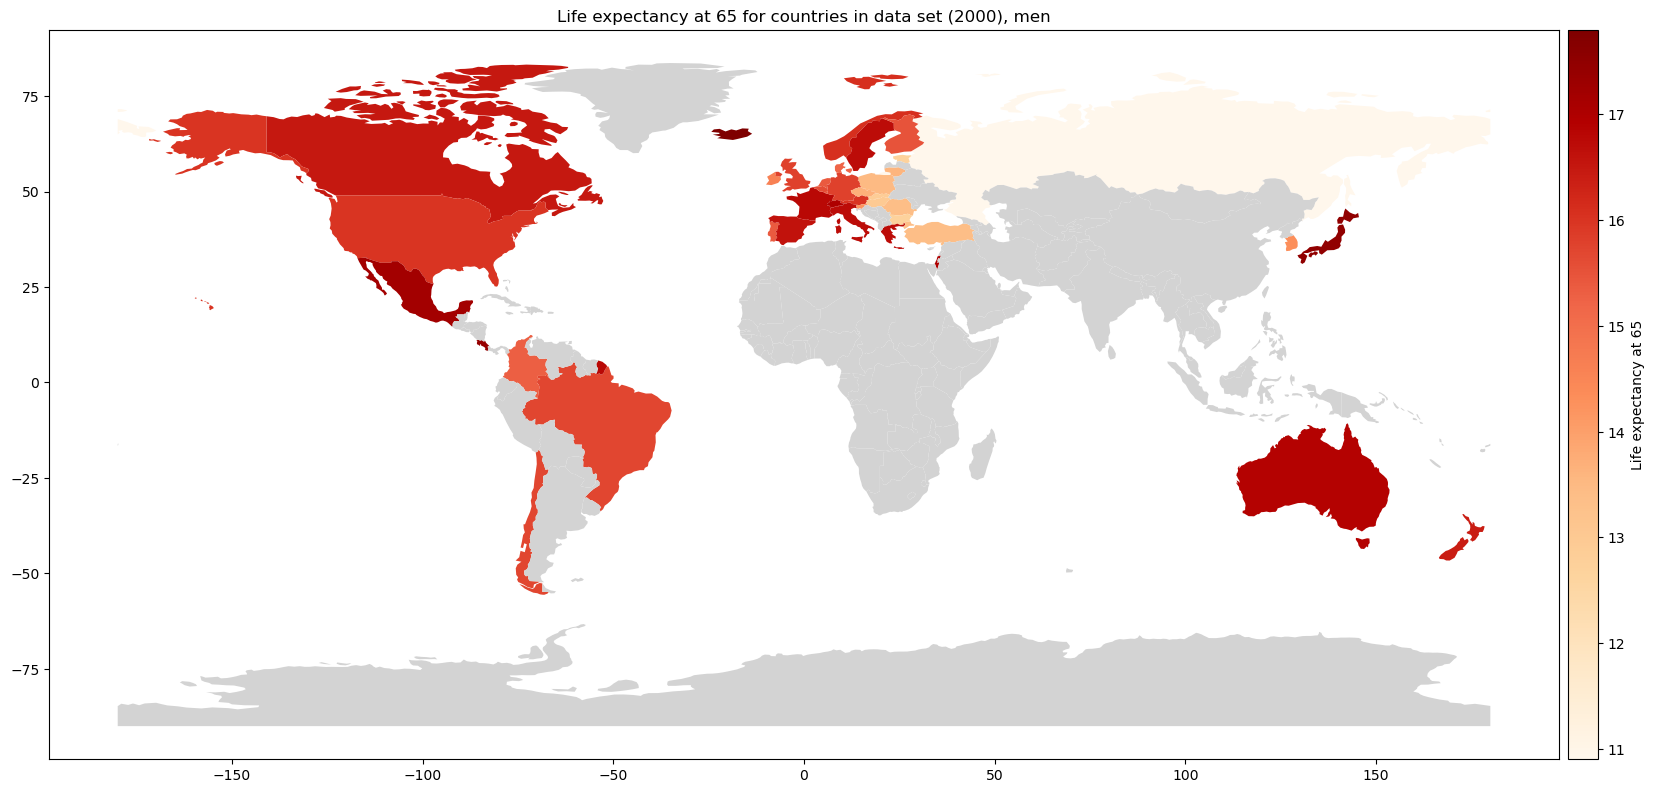

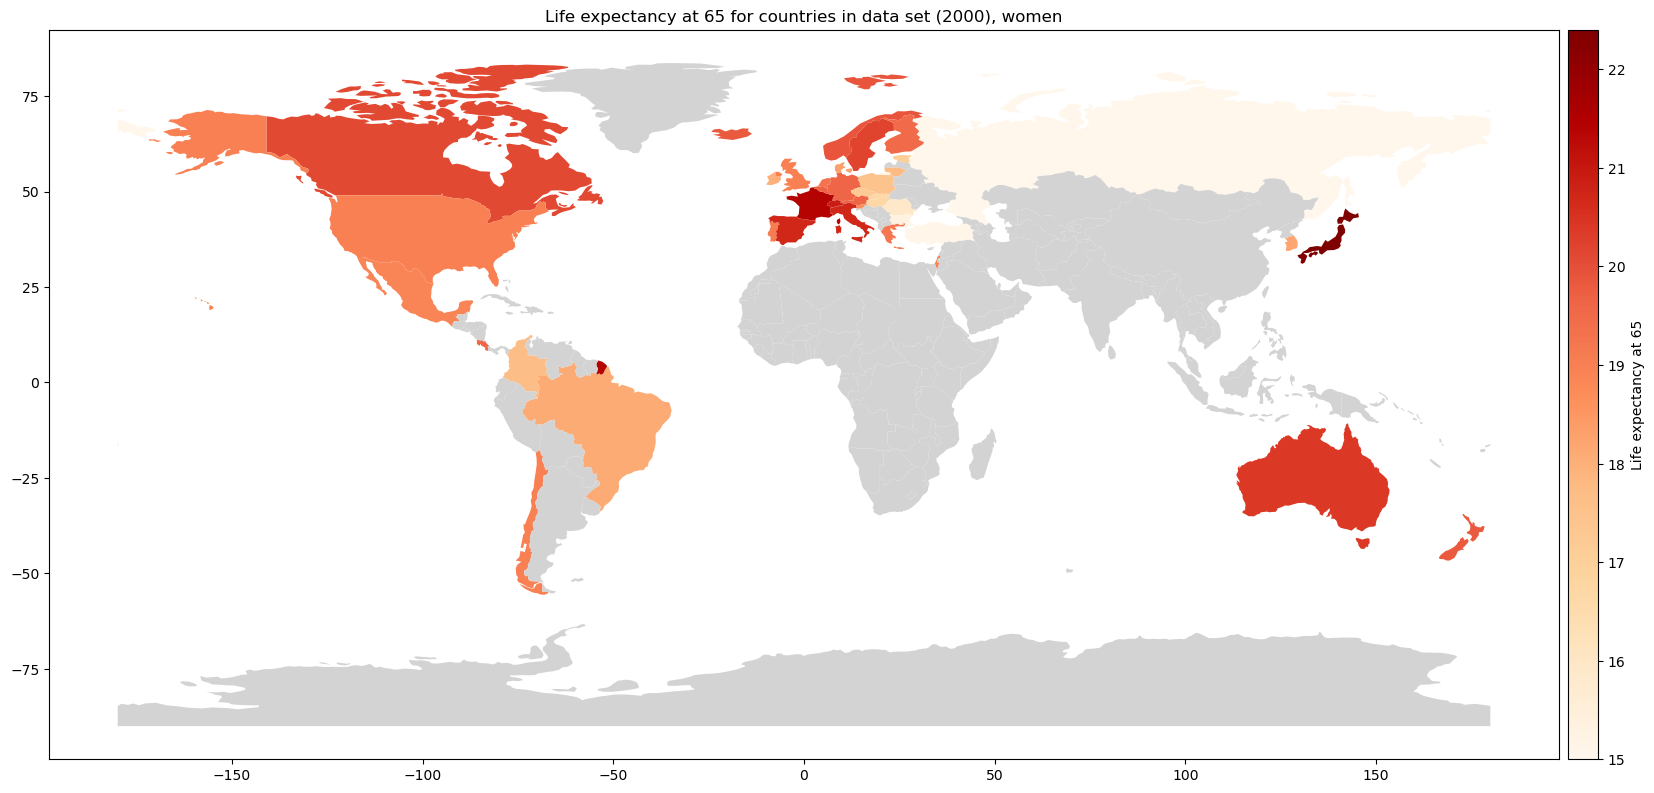

In [2]:
# making overview map for countries in data set

for data in ['men.csv', 'women.csv']:
    # rewrite to use in titles in final plot
    data_title = data.rstrip('.csv')
    # load and clean data
    mapdata = pd.read_csv(data)
    drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Flag Codes']
    mapdata.drop(drop, axis=1, inplace=True)

    # load data to make world map
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # merge map data to world map
    df_world_mapdata = df_world.merge(mapdata, how="left", left_on=['iso_a3'], right_on=['LOCATION'])

    # add visuals, labels and title
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    df_world_mapdata.plot(column="Value", ax=ax, cax=cax, cmap='OrRd',legend=True, legend_kwds={"label": "Life expectancy at 65"}, missing_kwds={'color':'lightgrey'})
    ax.set_title(f'Life expectancy at 65 for countries in data set (2000), {data_title}')


# Read and clean data

In [4]:
# importing data
alcohol = pd.read_csv('alcohol.csv')
life_exp_65 = pd.read_csv('lifeexp65.csv')
overobese = pd.read_csv('overobese.csv')
smokers = pd.read_csv('smokers.csv')
social_support = pd.read_csv('socsupport.csv')
yrlifelost = pd.read_csv('yrlifelost.csv')

In [5]:
# clean alcohol data
drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
alcohol.drop(drop, axis=1, inplace=True)

alcohol.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'alcohol_sale'}, inplace=True)


# figure (alcohol)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='alcohol_sale', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(alcohol),
    country = widgets.Dropdown(description='country', 
                                    options=alcohol.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [6]:
alcohol_wide = pd.pivot(alcohol,index='country',columns='year',values='alcohol_sale')

col_dict = {}
for i in range(1960,2022):
    col_dict[str(i)] = f'alc{i}'

col_dict = {str(i) : f'alc{i}' for i in range(1960,2022)}

alcohol_wide.rename(columns =col_dict, inplace=True)

#drop_list=[*range(1960,2000)]
#drop_list.append(2021)

#alcohol_wide.drop(drop_list, axis=1, inplace=True)



In [7]:
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
life_exp_65.drop(drop, axis=1, inplace=True)

In [8]:
life_exp_65.rename(columns={'LOCATION':'country', 'SUBJECT':'sex','TIME':'year', 'Value':'exp_years'}, inplace=True)

In [9]:
life_exp_65_wide = pd.pivot_table(life_exp_65,index='country',columns='year',values='exp_years')

In [10]:
life_exp_65_wide

year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
AUS,14.05,14.15,14.00,14.05,13.75,13.95,13.75,14.05,13.75,14.05,...,20.55,20.65,20.80,20.90,20.95,21.00,21.25,21.35,21.65,NaN
AUT,13.35,13.75,13.40,13.40,13.75,13.30,13.65,13.40,13.40,13.20,...,19.70,19.85,20.15,19.70,20.10,20.00,20.05,20.20,19.45,19.60
BEL,13.45,14.05,13.70,13.50,14.05,13.80,13.85,13.90,13.55,13.60,...,19.50,19.60,20.15,19.85,20.15,20.20,20.25,20.50,19.20,20.40
BGR,14.55,14.80,13.70,14.50,14.80,14.45,14.50,13.95,14.45,13.70,...,15.60,16.05,15.85,15.80,16.05,15.95,16.10,16.15,15.00,13.65
BRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.85,17.95,18.15,18.25,18.40,18.50,18.70,18.80,18.95,NaN
CAN,NaN,14.80,NaN,NaN,NaN,NaN,15.15,NaN,NaN,NaN,...,20.30,20.45,20.55,20.55,20.60,20.70,20.75,20.85,20.75,NaN
CHE,14.00,14.45,14.00,13.80,14.50,14.20,14.35,14.65,14.45,14.50,...,20.80,20.90,21.15,20.90,21.45,21.40,21.60,21.65,20.75,21.65
CHL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.15,19.30,19.45,19.60,19.70,19.85,20.00,20.15,20.30,20.45
COL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.90,18.00,18.15,18.25,18.30,18.40,18.60,18.70,18.70,NaN


In [11]:
# clean life_exp_65 data
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
life_exp_65.drop(drop, axis=1, inplace=True)

life_exp_65.rename(columns={'LOCATION':'country', 'SUBJECT':'sex','TIME':'year', 'Value':'exp_years'}, inplace=True)

life_exp_65_wide = pd.pivot_table(life_exp_65,index='country',columns='year',values='exp_years')



KeyError: "['INDICATOR', 'MEASURE', 'FREQUENCY', 'Flag Codes'] not found in axis"

In [12]:
# figure (life_exp_65)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='exp_years', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(life_exp_65_wide),
    country = widgets.Dropdown(description='country', 
                                    options=life_exp_65_wide.country.unique(), 
                                    value='AUS')
);

#life_exp_65_long = pd.melt(life_exp_65_wide, id_vars='country',value_vars='year')

AttributeError: 'DataFrame' object has no attribute 'country'

In [13]:
# clean overobese data
drop = ['INDICATOR','MEASURE','FREQUENCY','Flag Codes']
overobese.drop(drop, axis=1, inplace=True)

overobese.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'share_obese'}, inplace=True)

# lav funktion som vælger enten self-reported eller den anden

# figure (overobese)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_obese', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(overobese),
    country = widgets.Dropdown(description='country', 
                                    options=overobese.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'FIN', 'FRA'…

In [14]:
# clean smokers data
I = smokers.SUBJECT.str.contains('WOMEN')
I |= smokers.SUBJECT.str.contains('MEN')
smokers.loc[I,:]
smokers = smokers.loc[I == False]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
smokers.drop(drop, axis=1, inplace=True)

smokers.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'smoking'}, inplace=True)


# figure (smokers)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='smoking', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(smokers),
    country = widgets.Dropdown(description='country', 
                                    options=smokers.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [15]:
# clean social_support data
I = social_support.SUBJECT.str.contains('TOT')
social_support.loc[I,:]
social_support = social_support.loc[I == True]

drop = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes']
social_support.drop(drop, axis=1, inplace=True)

social_support.rename(columns={'LOCATION':'country', 'TIME':'year', 'Value':'share_support'}, inplace=True)


# figure (social_support)
def plot(df, country):
    I=df['country']==country
    ax=df.loc[I,:].plot(x='year', y='share_support', legend=False)

widgets.interact(plot, 
    df = widgets.fixed(social_support),
    country = widgets.Dropdown(description='country', 
                                    options=social_support.country.unique(), 
                                    value='AUS')
);

interactive(children=(Dropdown(description='country', options=('AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN'…

In [16]:
# overview
alcohol_wide
#life_exp_65_wide
#overobese_wide
#smokers_wide
#social_support_wide

year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,8.3,7.9,8.5,8.4,8.3,8.0,8.0,NaN,NaN
AUS,9.3,9.4,9.5,9.8,10.1,10.0,10.3,10.8,11.1,11.6,...,10.0,9.9,9.7,9.8,9.5,9.5,NaN,NaN,NaN,NaN
AUT,8.8,9.4,9.4,10.1,10.7,11.2,13.0,12.7,13.4,13.2,...,12.1,11.9,12.2,11.2,11.4,11.3,11.3,11.6,11.3,NaN
BEL,NaN,NaN,NaN,9.9,10.5,10.8,10.3,10.7,11.2,11.5,...,10.1,10.3,10.6,10.4,9.4,9.3,9.2,9.2,NaN,NaN
BGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.9,10.3,10.3,10.9,11.1,10.9,11.5,11.2,NaN,NaN
BRA,NaN,NaN,NaN,1.9,2.0,1.9,1.8,2.6,2.7,2.7,...,7.1,6.9,6.9,6.6,6.4,6.3,6.2,6.1,NaN,NaN
CAN,7.0,7.1,7.3,7.5,7.6,7.8,8.1,8.3,8.3,8.5,...,8.3,8.2,8.0,8.0,8.1,8.2,8.2,8.0,8.1,NaN
CHE,12.1,12.7,12.9,13.1,13.8,13.7,13.6,13.6,13.6,14.0,...,9.9,9.8,9.5,9.5,9.3,9.2,9.1,9.3,8.9,NaN
CHL,NaN,NaN,NaN,11.1,11.6,9.7,11.3,11.4,11.6,9.1,...,8.3,7.2,7.9,7.9,6.4,5.7,6.3,7.1,NaN,NaN


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [17]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

In [18]:
#merging the data
smokeralc = pd.merge(smokers,alcohol,on=['country','year'],how='outer')

In [19]:
merged = pd.merge(smokeralc, social_support,on=['country','year'],how='outer')
merged

,country,year,smoking,alcohol_sale,share_support
0,AUS,1964,43.0,10.1,NaN
1,AUS,1966,40.0,10.3,NaN
2,AUS,1969,37.0,11.6,NaN
3,AUS,1974,37.8,13.1,NaN
4,AUS,1976,38.4,13.1,NaN
...,...,...,...,...,...
2623,RUS,2020,NaN,NaN,88.545778
2624,RUS,2021,NaN,NaN,85.969644
2625,SVN,2021,NaN,NaN,95.398196
2626,SVN,2022,NaN,NaN,93.825366


In [20]:
merged.set_index(['country','year'])

smoking  alcohol_sale  share_support
country year                                      
AUS     1964     43.0          10.1            NaN
        1966     40.0          10.3            NaN
        1969     37.0          11.6            NaN
        1974     37.8          13.1            NaN
        1976     38.4          13.1            NaN
...               ...           ...            ...
RUS     2020      NaN           NaN      88.545778
        2021      NaN           NaN      85.969644
SVN     2021      NaN           NaN      95.398196
        2022      NaN           NaN      93.825366
ZAF     2021      NaN           NaN      92.006225

[2628 rows x 3 columns]

CODE TIL FÆLLES WIDGET

In [35]:
def plot(df, country, var):
    I=df['country']== country
   

    ax=df.loc[I,:].plot(x='year', y=str(var), legend=False) 
    
def plot_timeseries(df):
    widgets.interact(plot, 
    df = widgets.fixed(df),
    var = widgets.Dropdown(
        description='variable', 
        options=['smoking','alcohol_sale','share_support'], 
        value='smoking'),
    country = widgets.Dropdown(
        description='country', 
        options=df.country.value_counts().index.to_list(), 
        value='AUS')          
);

In [36]:
plot_timeseries(merged)

interactive(children=(Dropdown(description='country', options=('AUS', 'FIN', 'SWE', 'NOR', 'NLD', 'HUN', 'USA'…

In [23]:
plot_timeseries(merged)

TraitError: Invalid selection: value not found

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.